In [1]:
%run ./PPS_Expansion_Model.ipynb

/home/renato-paredes/.virtualenvs/gifted/lib/python3.13/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


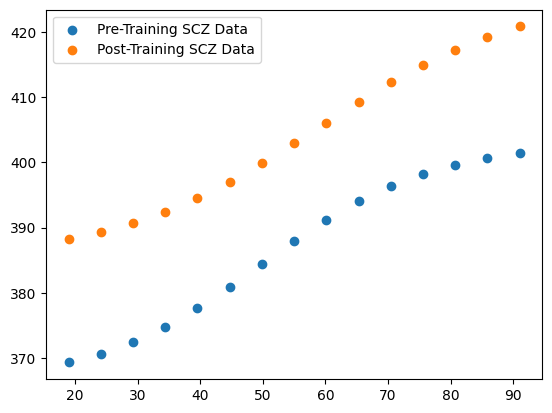

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###SCZ
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)

##Post-Training
###SCZ
ymin = 385
ymax = 426
scz_cp_post = 100 - 1.361 * v
scz_slope_post = 1 / 0.061  # negative

SCZ_RTs_post = RTsig(a_distances, scz_cp_post, scz_slope_post)

plt.scatter(a_distances, SCZ_RTs, label="Pre-Training SCZ Data")
plt.scatter(a_distances, SCZ_RTs_post, label="Post-Training SCZ Data")
plt.legend()

In [4]:
from scipy.optimize import differential_evolution

Lex, Pr = 1.963e00, 1.044e-01

SCZLt, SCZLa, SCZLv = Lw(Lex, 0.05, 1, 4, Lex, 0.05, 20, 80, Lex, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

rho_0 = 7.533e-03
stim_counts = 10

sigav_x, locav_x = 5.394e00, 3.271e01


def train_sczmodel(theta):
    k = theta[0]

    SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
        stim_counts,
        simtime,
        ts,
        SCZLt,
        SCZLa,
        SCZLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        Pr,
        rho_0,
        6.5,
        6.5,
        k,
        k,
        0.05,
        sigav_x,
        locav_x,
    )

    _, _, _, _, SCZrtpost = experiment(
        ts,
        simtime,
        a_distances,
        5,
        SCZLt,
        SCZLa,
        SCZLv,
        HCWt,
        SCZWa_tr[:, :, -1, -1],
        SCZWv_tr[:, :, -1, -1],
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = SCZrtpost
    yf = SCZ_RTs_post

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 0.1)]
train_sczmodel_res = differential_evolution(
    train_sczmodel, bounds, disp=True, workers=30, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 13.679867113550287
differential_evolution step 2: f(x)= 13.679867113550287
differential_evolution step 3: f(x)= 13.630896446001334
differential_evolution step 4: f(x)= 12.678527495247376
differential_evolution step 5: f(x)= 12.678527495247376
differential_evolution step 6: f(x)= 12.678527495247376
differential_evolution step 7: f(x)= 12.678527495247376
differential_evolution step 8: f(x)= 12.678527495247376
differential_evolution step 9: f(x)= 12.678527495247376
differential_evolution step 10: f(x)= 12.678527495247376
differential_evolution step 11: f(x)= 12.678527495247376


In [5]:
print(train_sczmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 12.678527495247376
                   x: [ 3.364e-02]
                 nit: 11
                nfev: 180
          population: [[ 3.364e-02]
                       [ 3.385e-02]
                       ...
                       [ 3.403e-02]
                       [ 3.412e-02]]
 population_energies: [ 1.268e+01  1.268e+01 ...  1.268e+01  1.268e+01]


In [3]:
## Fitted model

stim_counts = 10
k_a = 3.364e-02
k_v = 3.364e-02

Lex, Pr = 1.963e00, 1.044e-01
rho_0 = 7.533e-03
sigav_x, locav_x = 5.394e00, 3.271e01

SCZLt, SCZLa, SCZLv = Lw(Lex, 0.05, 1, 4, Lex, 0.05, 20, 80, Lex, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    Pr,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    sigav_x,
    locav_x,
)


_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts,
    simtime,
    a_distances,
    5,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    SCZWa_tr[:, :, -1, -1],
    SCZWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

0.9185668827719049 340.91409238972835


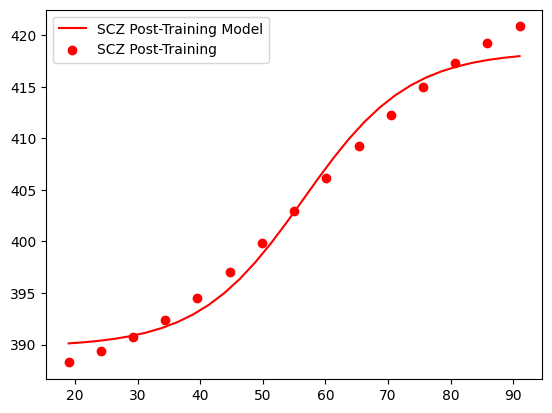

In [4]:
xf = SCZ_Model_RTs_post
yf = SCZ_RTs_post
m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
    xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
)
bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

ymin, ymax = np.min(m * xf + bias), np.max(m * xf + bias)
dc, h = fitting(a_distances, m * xf + bias)
mydistances_exp = np.linspace(a_distances[0], a_distances[-1], 30)
yf_exp = RTsig(mydistances_exp, dc, h)

plt.figure(1)
plt.plot(mydistances_exp, yf_exp, label="SCZ Post-Training Model", color="r")
plt.scatter(a_distances, yf, label="SCZ Post-Training", color="r")
plt.legend()
print(m, bias)

In [5]:
def adjrmse(model, data, k):
    sse = np.sum(np.square(data - model))
    n = len(model)
    return np.sqrt(sse / (n - k))


scz_error = adjrmse(m * xf + bias, yf, 5)
print(scz_error)

1.45482970473392


(2.0, 7.0)

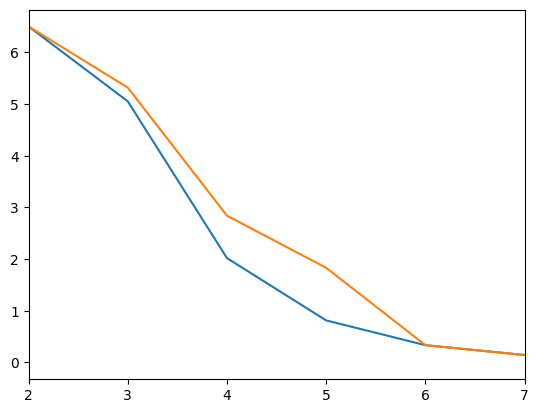

In [8]:
plt.plot(SCZWa_tr[:, 1, 0, 0])
plt.plot(SCZWa_tr[:, 1, -1, -1])
plt.xlim(2, 7)

Text(0.5, 1.0, 'Increased forgetting rate model')

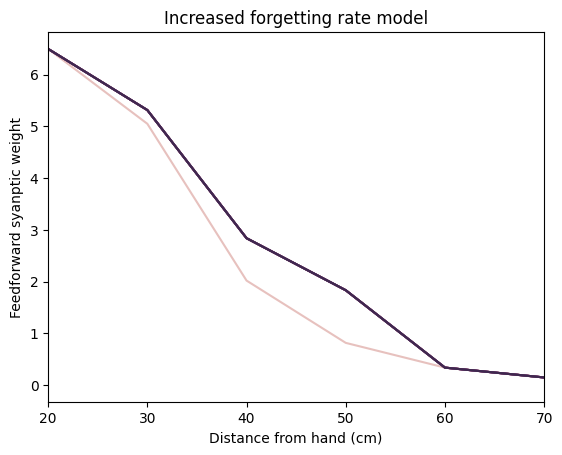

In [25]:
import seaborn as sns

sns.lineplot(
    SCZWa_tr[:, 1, :, 0], palette="ch:dark=.20,light=.80", dashes=False, legend=False
)
plt.xlim(2, 7)
plt.xticks(ticks=[2, 3, 4, 5, 6, 7], labels=[20, 30, 40, 50, 60, 70])
plt.xlabel("Distance from hand (cm)")
plt.ylabel("Feedforward syanptic weight")
plt.title("Increased forgetting rate model")

In [10]:
_, _, _, _, SCZ_Model_RTs_pre = experiment(
    ts,
    simtime,
    a_distances,
    5,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    Pr,
    0,
)

In [11]:
SCZ_RTs_model_pre_scaled = fit_RT(SCZ_Model_RTs_pre, SCZ_RTs_post)
SCZ_Model_RTs_post_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

ymin, ymax = np.min(SCZ_RTs_model_pre_scaled), np.max(SCZ_RTs_model_pre_scaled)
SCZ_Pr_CP_model_pre, SCZ_Pr_SLOPE_model_pre = fitting(
    a_distances, SCZ_RTs_model_pre_scaled
)

ymin, ymax = np.min(SCZ_Model_RTs_post_scaled), np.max(SCZ_Model_RTs_post_scaled)
SCZ_Pr_CP_model_post, SCZ_Pr_SLOPE_model_post = fitting(
    a_distances, SCZ_Model_RTs_post_scaled
)

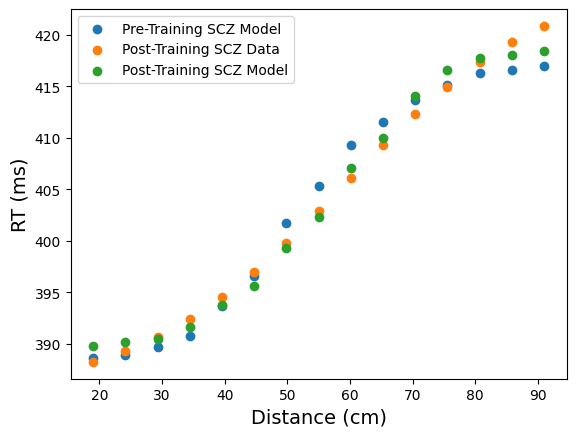

In [12]:
plt.scatter(a_distances, SCZ_RTs_model_pre_scaled, label="Pre-Training SCZ Model")
plt.scatter(a_distances, SCZ_RTs_post, label="Post-Training SCZ Data")
plt.scatter(a_distances, SCZ_Model_RTs_post_scaled, label="Post-Training SCZ Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()

In [13]:
print("Delta CP:", SCZ_Pr_CP_model_post - SCZ_Pr_CP_model_pre)
print("Delta Slope:", 1 / SCZ_Pr_SLOPE_model_post - 1 / SCZ_Pr_SLOPE_model_pre)

Delta CP: 4.312869720231554
Delta Slope: -0.003422991717064311
